In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('mps')

train = dsets.CIFAR10(root='data', download=True, train=True, transform = transforms.ToTensor())
val = dsets.CIFAR10(root='data', download=True, train=False, transform = transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Text(0.5, 1.0, '0')

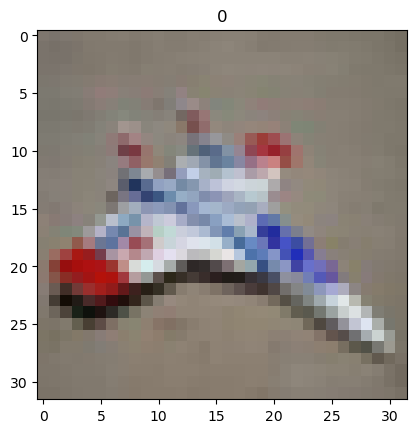

In [3]:
num = 30

plt.imshow(train[num][0].permute(1, 2 ,0))
plt.title(train[num][1])

In [4]:
len(train)

50000

In [5]:
train[0][0].shape

torch.Size([3, 32, 32])

In [6]:
trainloader = DataLoader(dataset=train, batch_size = 100)
valloader = DataLoader(dataset=val, batch_size = 3000)

In [11]:
torch.manual_seed(2)
p = 0.5

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7, 7), padding=2, stride=1),
            nn.BatchNorm2d(32), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, dilation=1)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4, 4), padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=(2, 2), stride=1, dilation=1)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2),
            nn.BatchNorm2d(128), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=(2, 2), stride=1, dilation=1)
        )
        
        self.flat = nn.Flatten(1)
        self.linear1 = nn.Linear(3200, 2000)
        self.dp1 = nn.Dropout(p)
        self.linear2 = nn.Linear(2000, 1000)
        self.dp2 = nn.Dropout(p)
        self.linear3 = nn.Linear(1000, 500)
        self.linear4 = nn.Linear(500, 10)
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flat(x)
        x = torch.relu(self.linear1(x))
        x = self.dp1(x)
        x = torch.relu(self.linear2(x))
        x = self.dp2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x
    
model = Net()
model.to(device)
model((train[0][0].unsqueeze(0)).to(device)).shape

torch.Size([1, 10])

In [12]:
optimizer = optim.SGD(model.parameters(), lr = 0.004, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [13]:
epochs = 100

COST = []
ACCURACY = []

for epoch in range(epochs):
    
    i = 0
    
    model.train()
    for x,y in trainloader:
        
        x, y = x.to(device), y.to(device)
        z = model(x)
        loss = criterion(z, y)
        COST.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    correct = 0
    total = 0
    
    model.eval()
    for x,y in valloader:
        
        x, y = x.to(device), y.to(device)
        
        z = model(x)
        _, yhat = torch.max(z, 1)
        
        correct += (yhat == y).sum().item()
        total += len(y)
        
    accuracy = (correct/total) * 100
    ACCURACY.append(accuracy)
    print('epoch ' + str(epoch) + ' accuracy: ' + str(accuracy))

epoch 0 accuracy: 46.1
epoch 1 accuracy: 51.64
epoch 2 accuracy: 45.53
epoch 3 accuracy: 56.11000000000001
epoch 4 accuracy: 67.73
epoch 5 accuracy: 67.75999999999999
epoch 6 accuracy: 66.86
epoch 7 accuracy: 66.66
epoch 8 accuracy: 55.089999999999996
epoch 9 accuracy: 59.38
epoch 10 accuracy: 64.71000000000001
epoch 11 accuracy: 73.72999999999999
epoch 12 accuracy: 72.26
epoch 13 accuracy: 75.0
epoch 14 accuracy: 74.11999999999999
epoch 15 accuracy: 75.33
epoch 16 accuracy: 77.52
epoch 17 accuracy: 76.13
epoch 18 accuracy: 77.0
epoch 19 accuracy: 78.53
epoch 20 accuracy: 77.69
epoch 21 accuracy: 72.58
epoch 22 accuracy: 79.11
epoch 23 accuracy: 75.82
epoch 24 accuracy: 76.38000000000001
epoch 25 accuracy: 72.77
epoch 26 accuracy: 75.07000000000001
epoch 27 accuracy: 77.4
epoch 28 accuracy: 74.53
epoch 29 accuracy: 79.36999999999999
epoch 30 accuracy: 75.75
epoch 31 accuracy: 76.29
epoch 32 accuracy: 80.65
epoch 33 accuracy: 80.54
epoch 34 accuracy: 78.93
epoch 35 accuracy: 80.58
epoch

Text(0.5, 0, 'iterations')

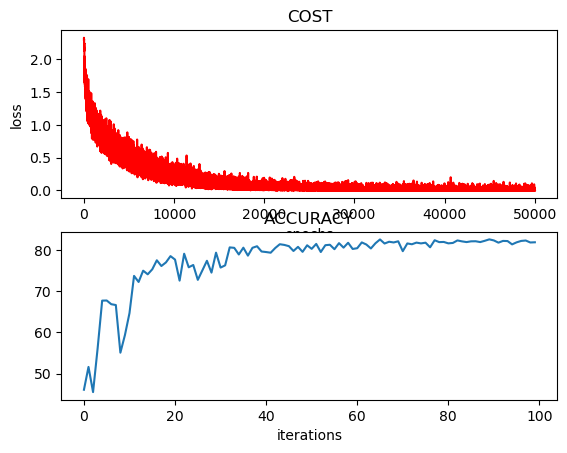

In [14]:
plt.subplot(2, 1, 1)
plt.plot(COST, c='r')
plt.title('COST')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.subplot(2, 1, 2)
plt.plot(ACCURACY)
plt.title('ACCURACY')
plt.xlabel('iterations')

In [15]:
train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']